## Using Llama 3 for Building AI Agents

__Comprehensive guide to building AI Agents with Llama 3.1 function calling capabilities.__

## Introduction

Let’s assume a scenario where you want to purchase something. You head over to an e-commerce website, use the search option to find what you want. Maybe you have a bunch of items to purchase as well. So the process is not very optimized, is it? Now think about this scenario: you head over to an application, explain what you want in plain English, and hit enter. All the searching and price comparisons are automatically done for you. Pretty cool, right? That’s exactly what we are going to build in this tutorial.

Let’s see some examples first.

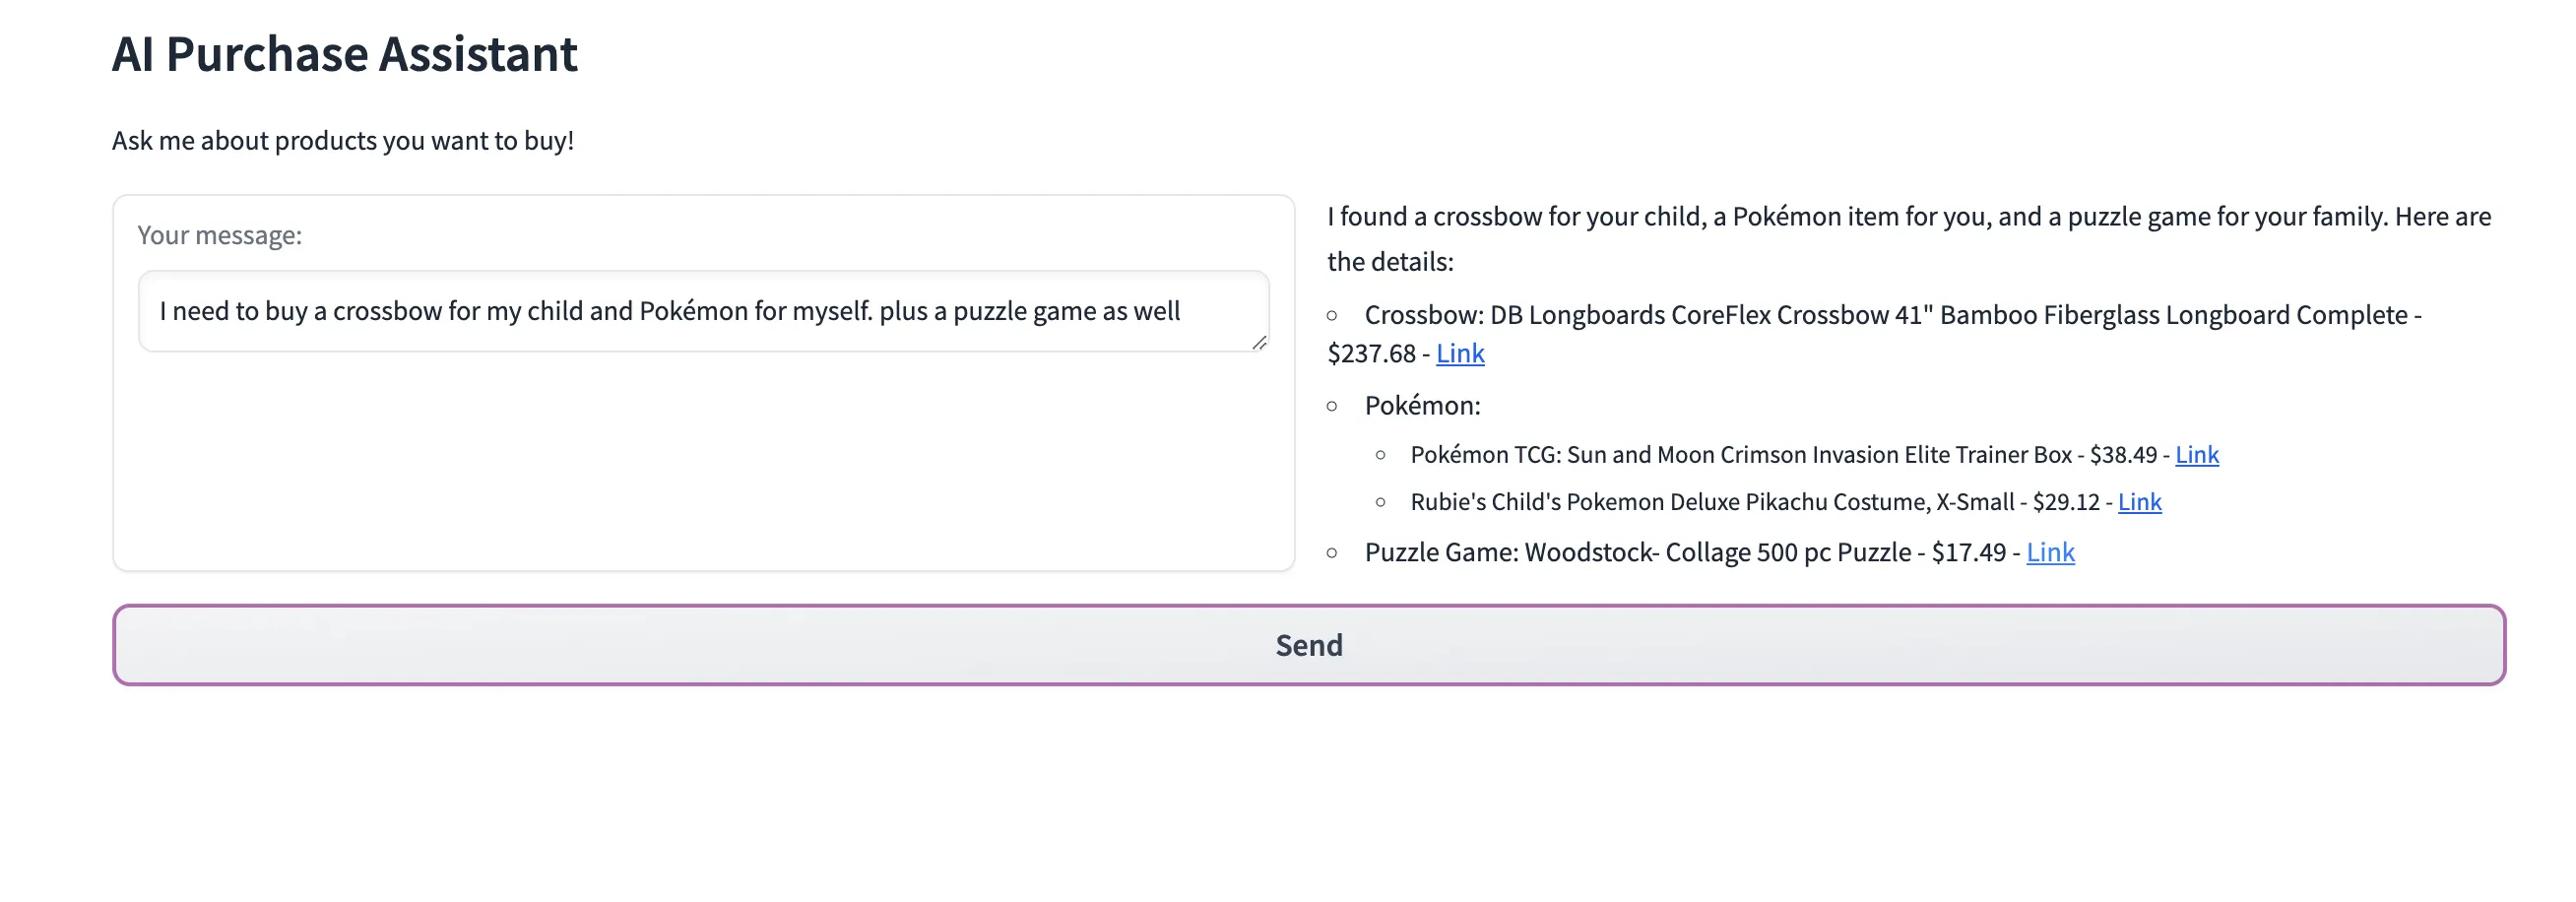

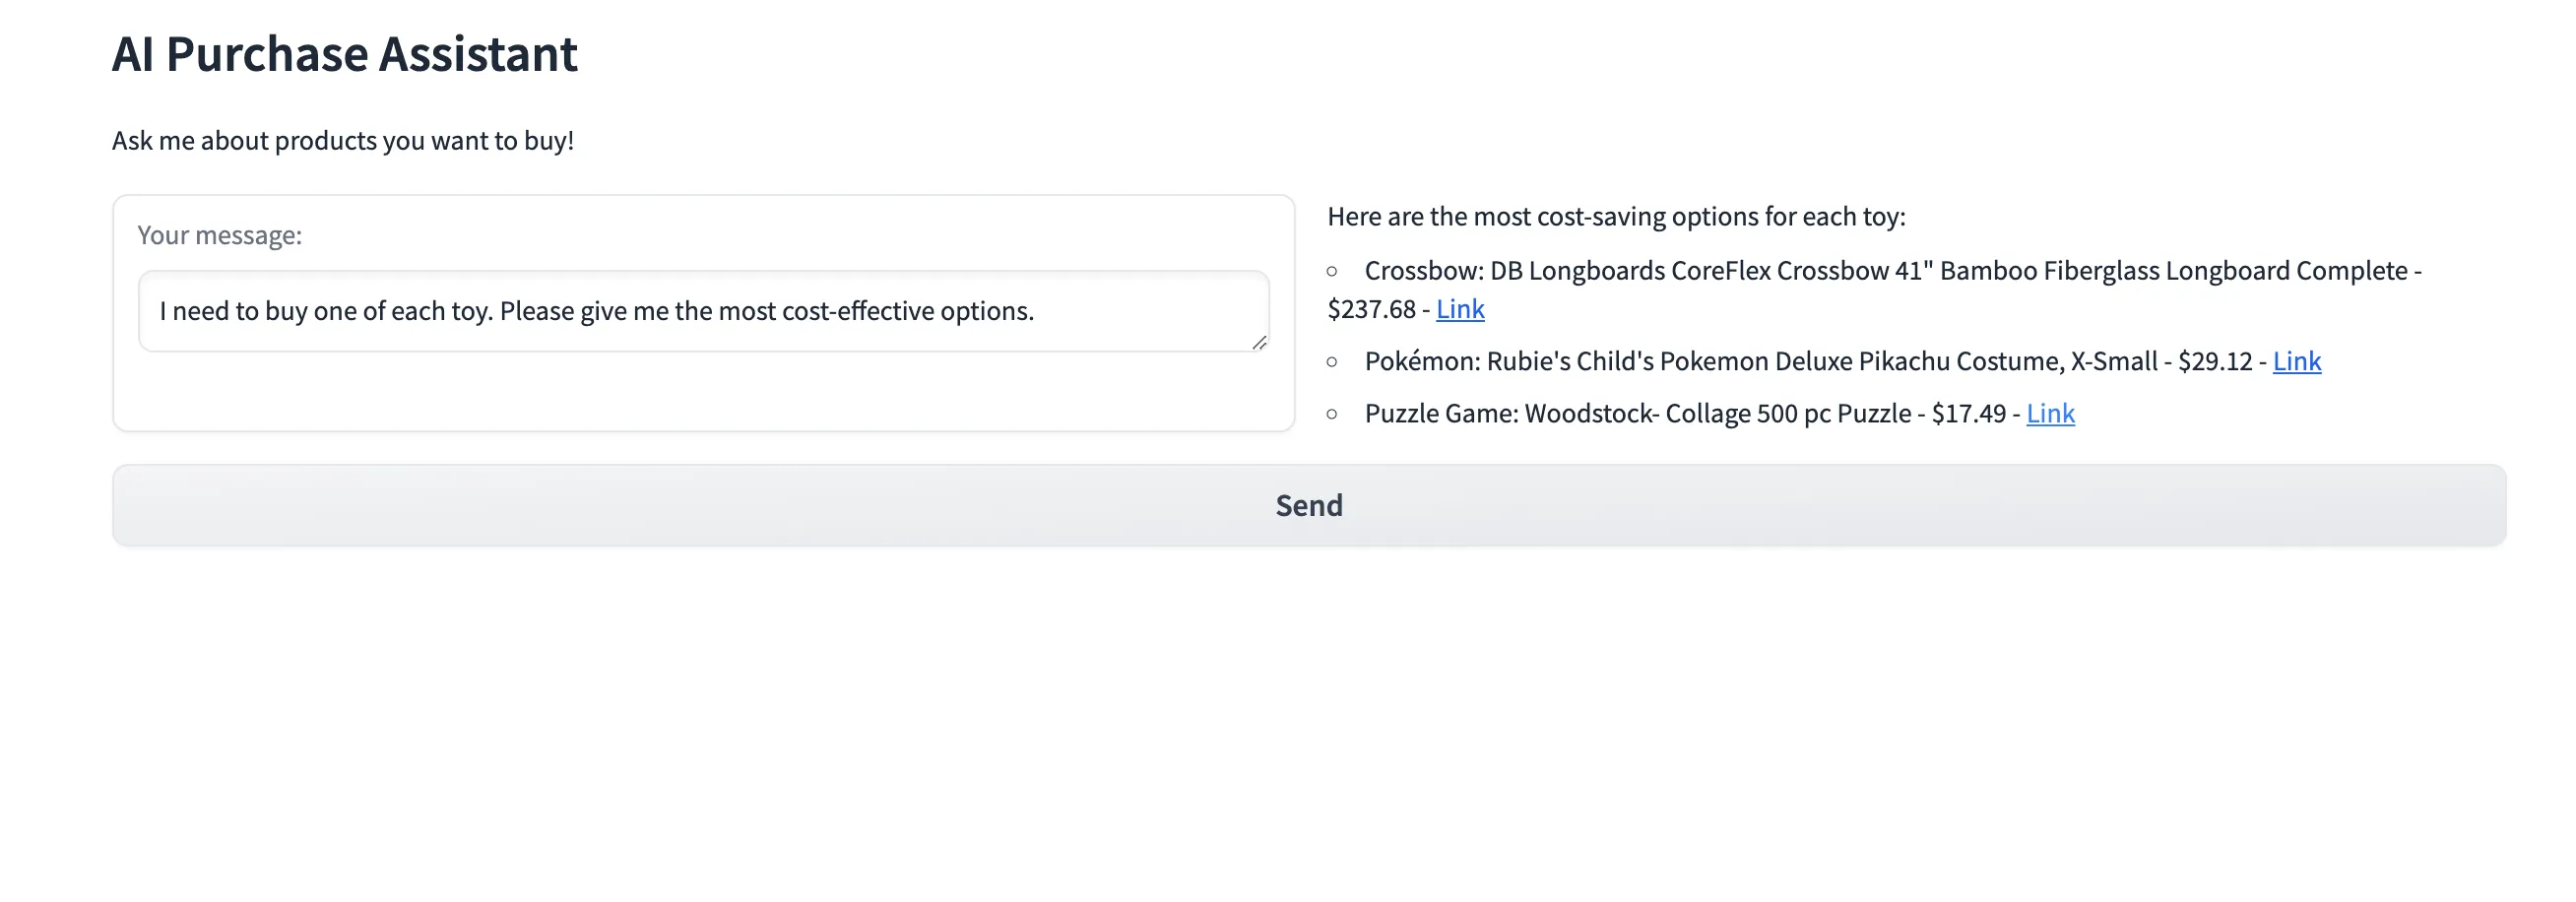

Alright, let’s bring life into this application. Here we are going to use Meta’s Llama 3.1 model with function calling capability. As per their announcement, the 3.1 models are capable of using tools and functions more effectively.

These are multilingual and have a significantly longer context length of 128K, state-of-the-art tool use, and overall stronger reasoning capabilities

However, for this article, I’m going to use Groq Cloud, hence I am going to use their Groq/Llama-3-Groq-70B-Tool-Use model. As per the initial workflow of this application, this should consist of an embedding model, a retriever, and two main tools for handling user purchase interests and cost-related concerns. Long story short, we need something similar to what we described in the diagram below.

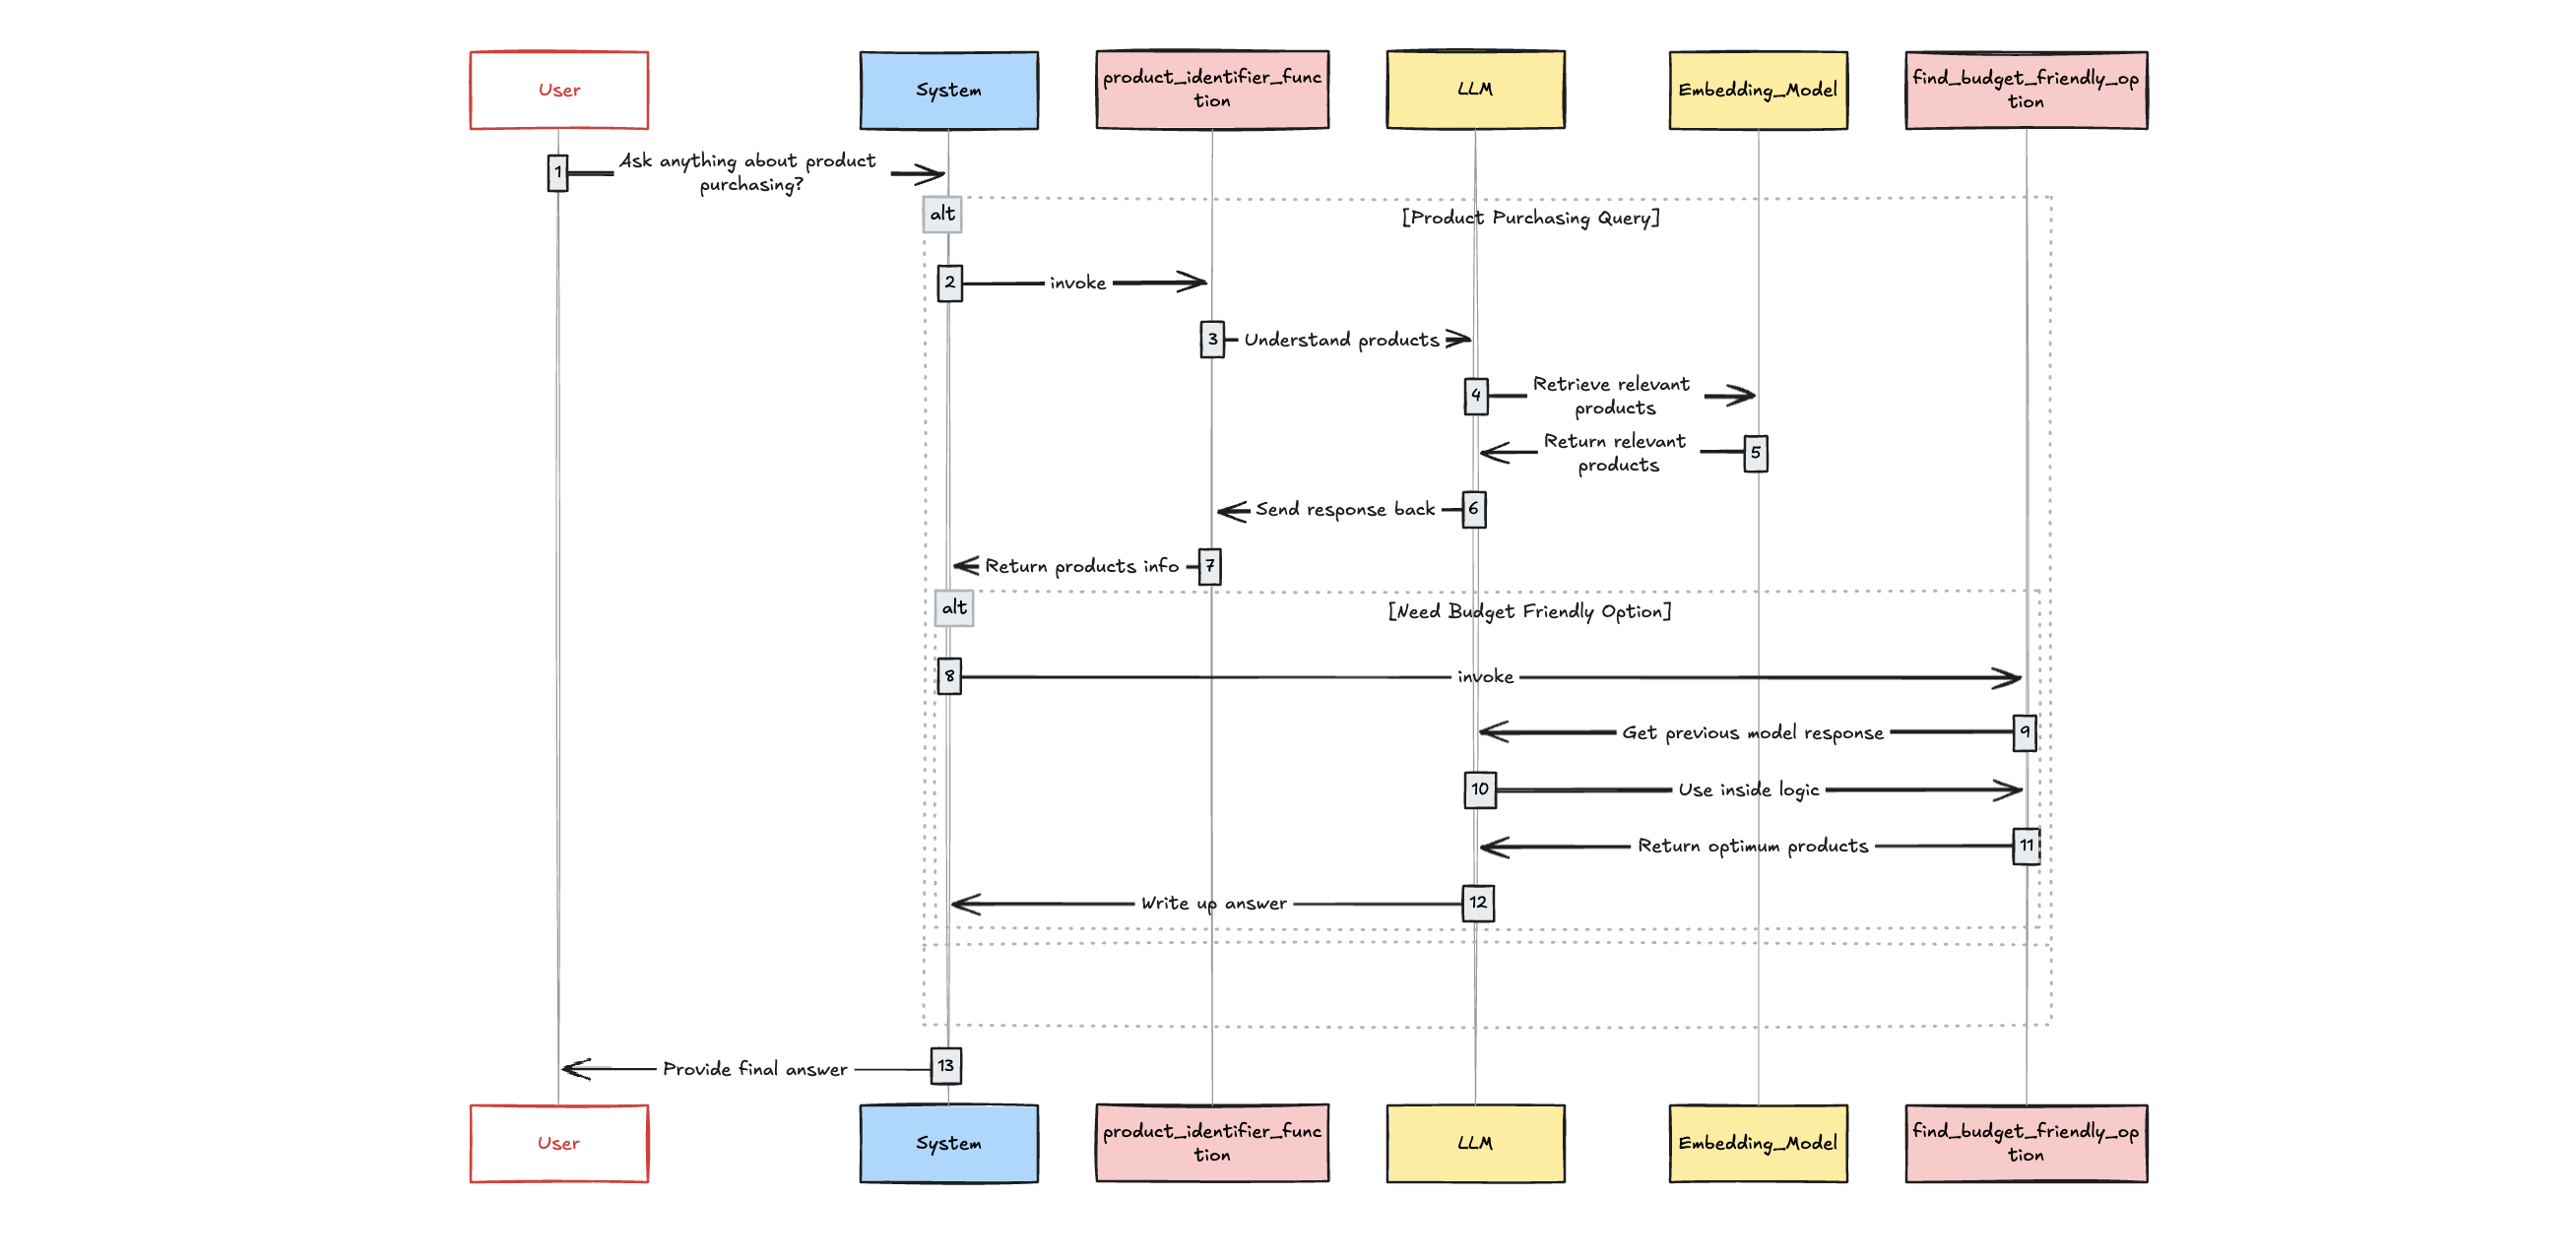

Now we have to use an LLM orchestration framework. For that, I am picking my all-time favourite, Haystack.

Okay, we got what we need. Let’s jump into the real work!

## Loading and Indexing data


Since we have an RAG pipeline, we should build a document indexing service as the first step. Since this is a demo, I am going to use the in-memory vector database that Haystack offers. Please note that each document in our vector database contains,

- content — which we use to perform similarity search
- Id — Unique identifier
- Price — Product price
- URL — Product URL

Let’s see how we can implement that.


In [8]:
from dotenv import load_dotenv
import re
from pprint import pprint
from ast import literal_eval
from typing import List
import json
import pandas as pd
from haystack import Pipeline, Document
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.generators import OpenAIGenerator
from haystack.utils import Secret
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.builders import PromptBuilder
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.dataclasses import ChatMessage

In [9]:
load_dotenv()

True

In [10]:
generator = lambda : OpenAIGenerator(
    api_key=Secret.from_env_var("GROQ_API_KEY"),
    api_base_url="https://api.groq.com/openai/v1",
    model="llama-3.1-70b-versatile",
    generation_kwargs = {"max_tokens": 512}
)

get_chat_generator = lambda **kwargs: OpenAIChatGenerator(
    api_key=Secret.from_env_var("GROQ_API_KEY"),
    api_base_url="https://api.groq.com/openai/v1",
    model="llama3-groq-70b-8192-tool-use-preview",
    generation_kwargs={"max_tokens": 512},
    **kwargs
)

## Load Dataset and Index

In [11]:
df = pd.read_csv("amazon_product_sample.csv")

document_store = InMemoryDocumentStore()
documents = [
    Document(
        content=item.product_name, 
        meta={
            "id":item.uniq_id, 
            "price":item.selling_price, 
            "url":item.product_url
            }
        ) for item in df.head(10).itertuples()
    ]

indexing_pipeline = Pipeline()

indexing_pipeline.add_component(
    instance=SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"), name="doc_embedder"
)

indexing_pipeline.add_component(instance=DocumentWriter(document_store= document_store), name="doc_writer")

indexing_pipeline.connect("doc_embedder.documents", "doc_writer.documents")

indexing_pipeline.run({"doc_embedder": {"documents": documents}})

Batches: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


{'doc_writer': {'documents_written': 10}}

Great, we’ve completed the first step of our AI agent application. Now it’s time to build the product identifier tool. To better understand the main task of the product identifier, let’s consider example below.

> User Query: I want to buy a camping boot, an charcoal and google pixel 9 back cover. Let’s understand our ideal workflow for product identifier function.

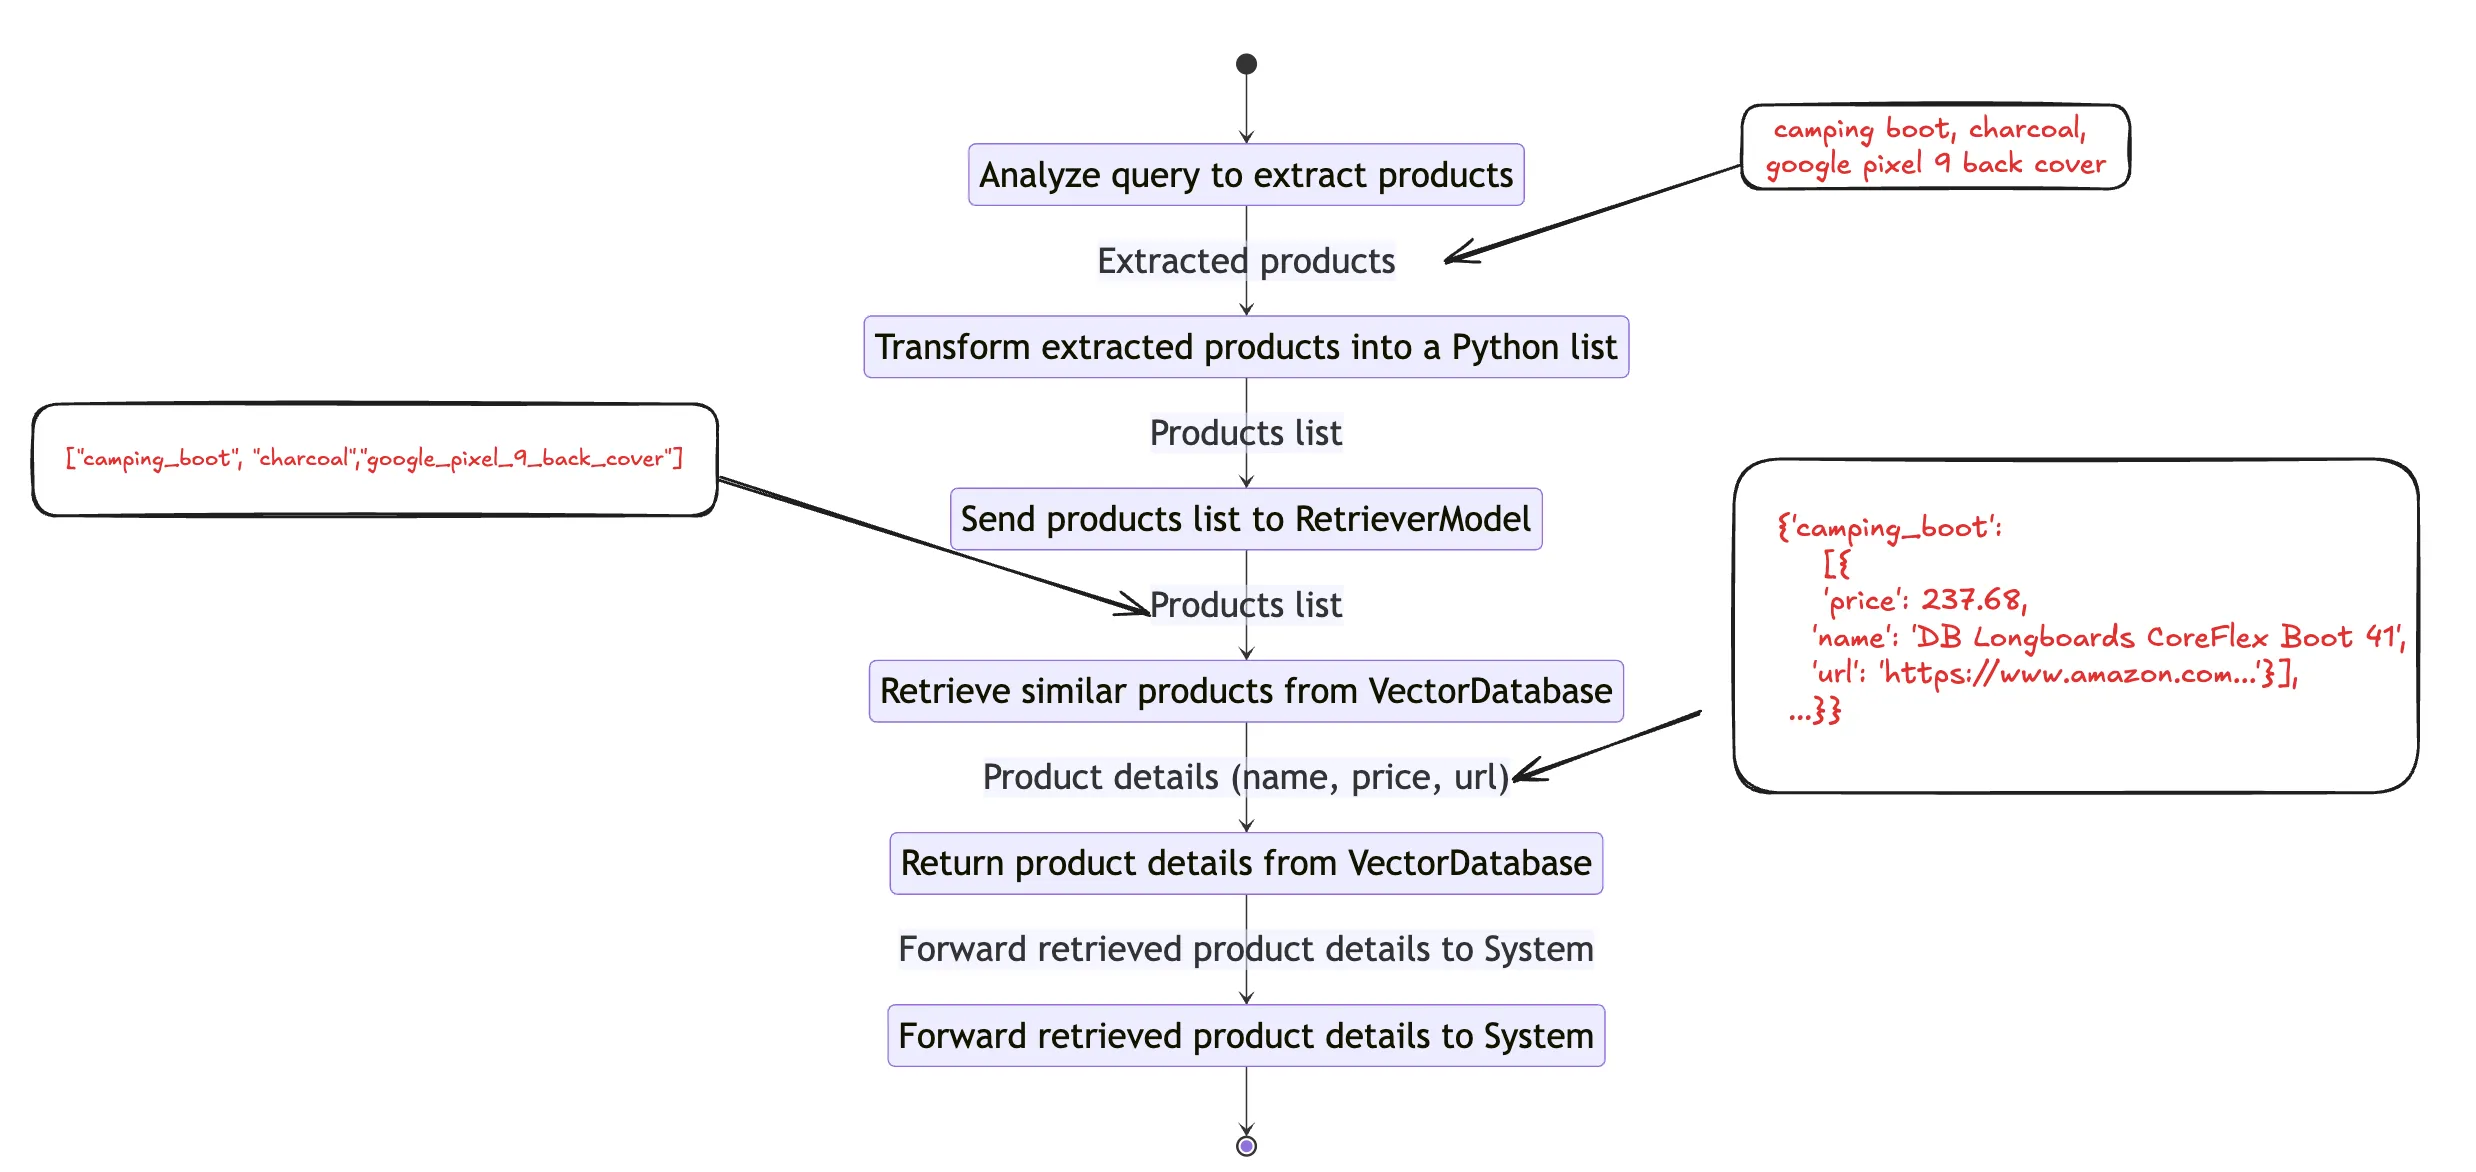

First, we need to create tool for analyse user query and identify user interested products. We can build such tool using below code snippets.

## Building User Query Analyzer

In [12]:
template = """
Understand the user query and list of products the user is interested in and return product names as list.
You should always return a Python list. Do not return any explanation.

Examples:
Question: I am interested in camping boots, charcoal and disposable rain jacket.
Answer: ["camping_boots","charcoal","disposable_rain_jacket"]

Question: Need a laptop, wireless mouse, and noise-cancelling headphones for work.
Answer: ["laptop","wireless_mouse","noise_cancelling_headphones"]

Question: {{ question }}
Answer:
"""

product_identifier = Pipeline()

product_identifier.add_component("prompt_builder", PromptBuilder(template=template))
product_identifier.add_component("llm", generator())

product_identifier.connect("prompt_builder", "llm")

🚅 Components
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)

Okay, now we have completed the half of our first function, now it’s time to complete function by adding RAG pipeline.

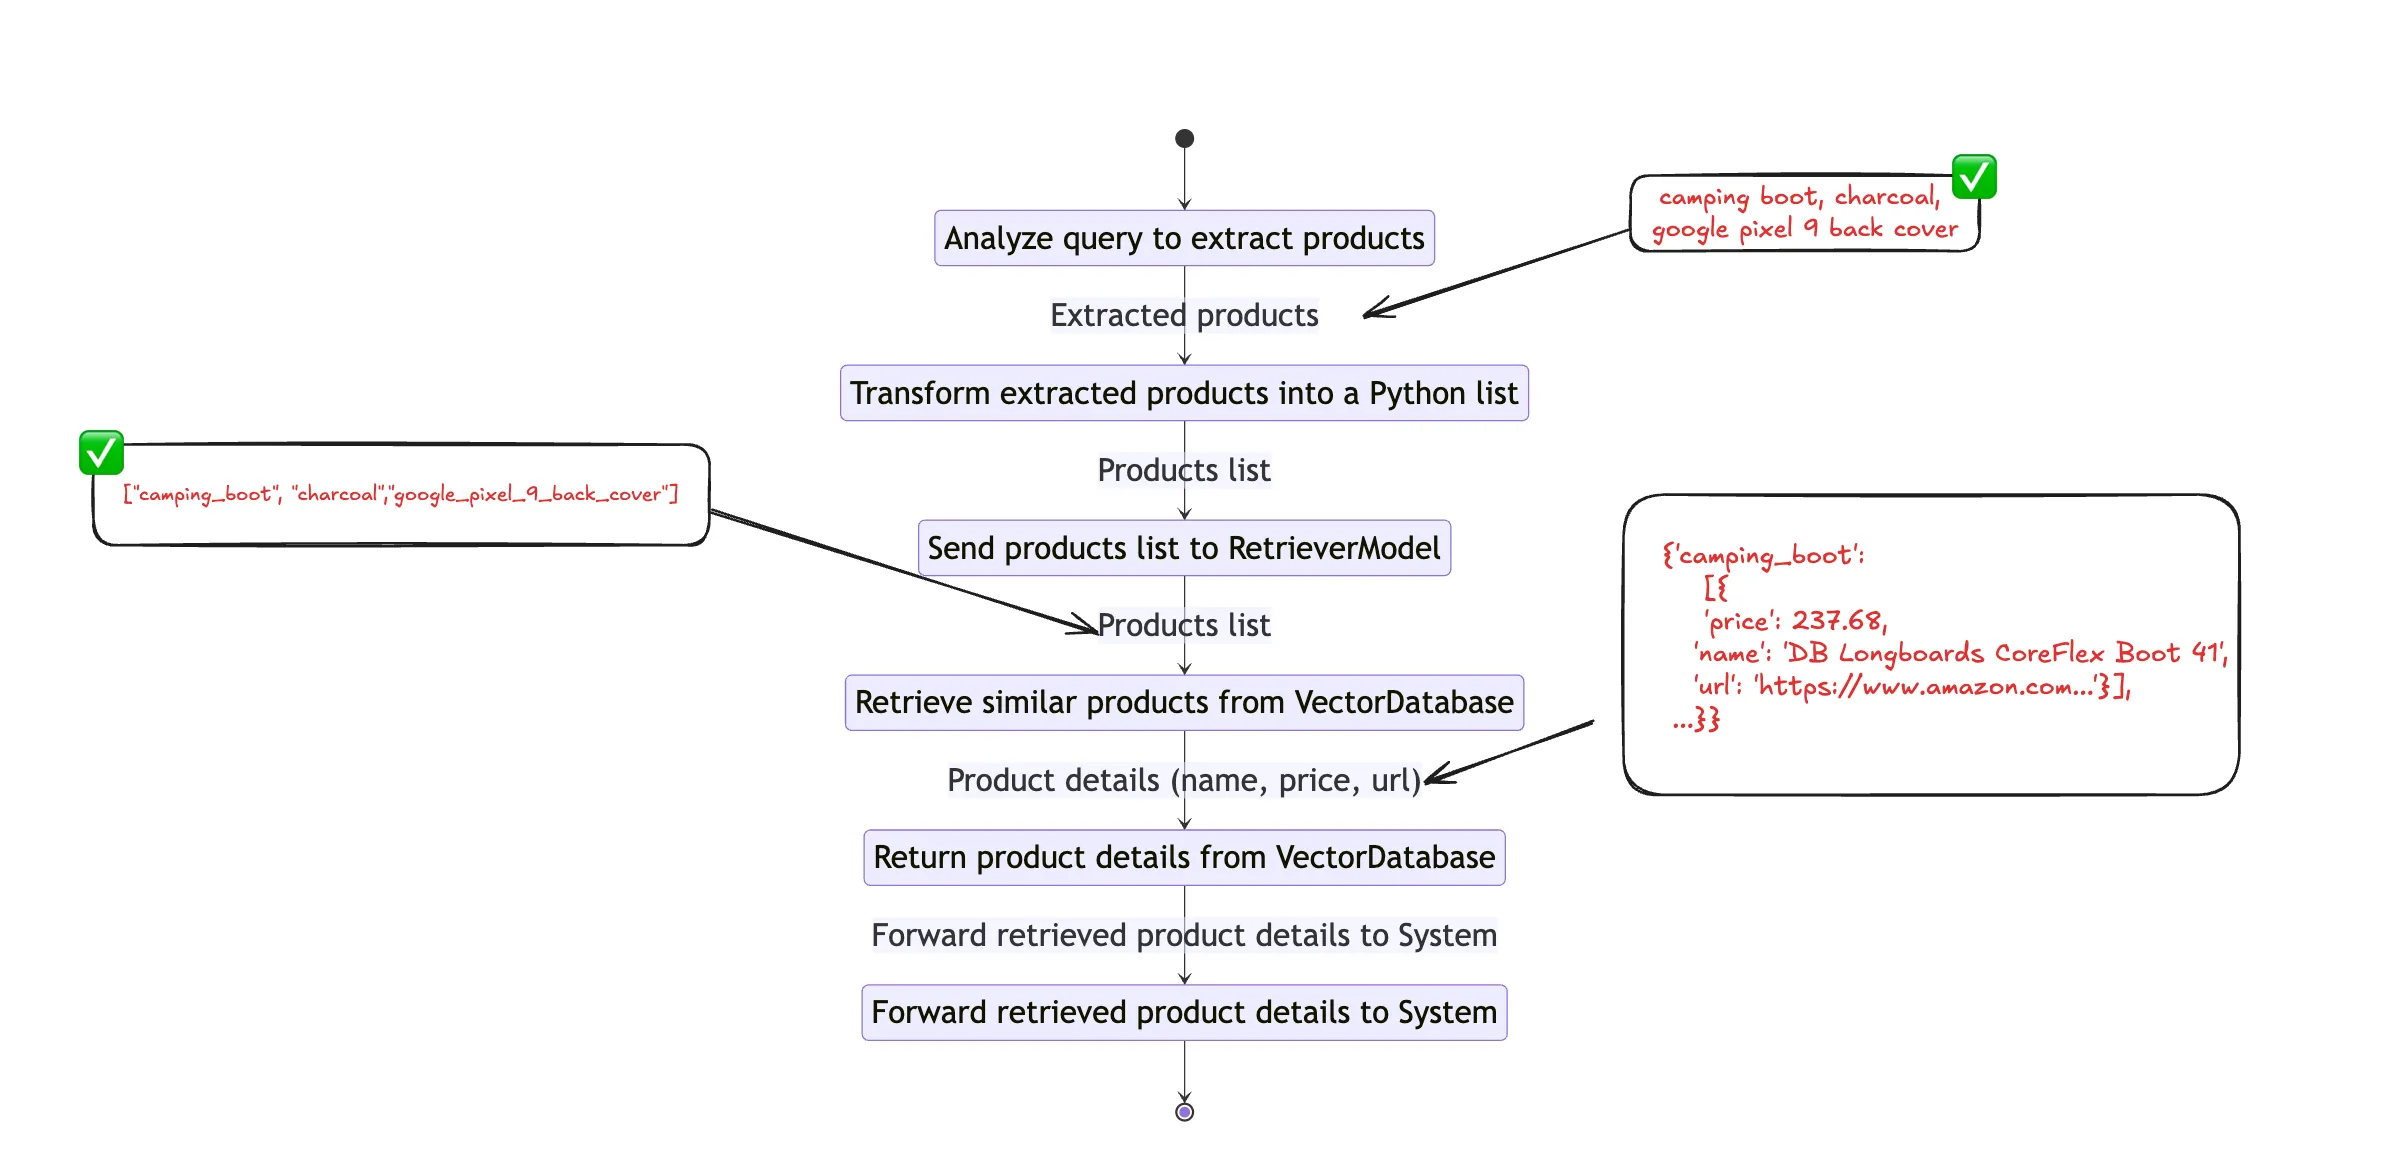

In [28]:
# testing product identifier tool
query = "I want crossbow and woodstock puzzle"
product_identifier.run({"prompt_builder": {"question": query}})

{'llm': {'replies': ['["crossbow","woodstock_puzzle"]'],
  'meta': [{'model': 'llama-3.1-70b-versatile',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 10,
     'prompt_tokens': 128,
     'total_tokens': 138,
     'prompt_time': 0.037991793,
     'completion_time': 0.04,
     'total_time': 0.077991793}}]}}

## Building RAG pipeline

In [14]:
template = """
Return product name, price, and url as a python dictionary. 
You should always return a Python dictionary with keys price, name and url for single product.
You should always return a Python list of dictionaries with keys price, name and url for multiple products.
Do not return any explanation.

Legitimate Response Schema:
{"price": "float", "name": "string", "url": "string"}
Legitimate Response Schema for multiple products:
[{"price": "float", "name": "string", "url": "string"},{"price": "float", "name": "string", "url": "string"}]

Context:
{% for document in documents %}
    product_price: {{ document.meta['price'] }}
    product_url: {{ document.meta['url'] }}
    product_id: {{ document.meta['id'] }}
    product_name: {{ document.content }}
{% endfor %}
Question: {{ question }}
Answer:
"""

rag_pipe = Pipeline()
rag_pipe.add_component("embedder", SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"))
rag_pipe.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store, top_k=5))
rag_pipe.add_component("prompt_builder", PromptBuilder(template=template))
rag_pipe.add_component("llm", generator())

rag_pipe.connect("embedder.embedding", "retriever.query_embedding")
rag_pipe.connect("retriever", "prompt_builder.documents")
rag_pipe.connect("prompt_builder", "llm")

🚅 Components
  - embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

After this stage, we have completed both RAG and Query Analyzer pipelines. Now it’s time to convert this into a tool. For that, we can use a regular function declaration as shown below. Here, creating a tool for the Agent is no different than creating a Python function. In case you have a question like

> How is it possible for the Agent to invoke this function?

The answer is simple: by using a model-specific tool schema. We will implement that in a future step. For now, it’s time to create a wrapper function that uses both the query analyzer and RAG pipeline.

## Combining product identifier with RAG pipeline

In [15]:
def product_identifier_func(query: str):
    product_understanding = product_identifier.run({"prompt_builder": {"question": query}})

    try:
        product_list = literal_eval(product_understanding["llm"]["replies"][0])
    except:
        return "No product found"

    results = {}

    for product in product_list:
        response = rag_pipe.run({"embedder": {"text": product}, "prompt_builder": {"question": product}})
        try:
            results[product] = literal_eval(response["llm"]["replies"][0])
        except:
            results[product] = {}
    
    return results

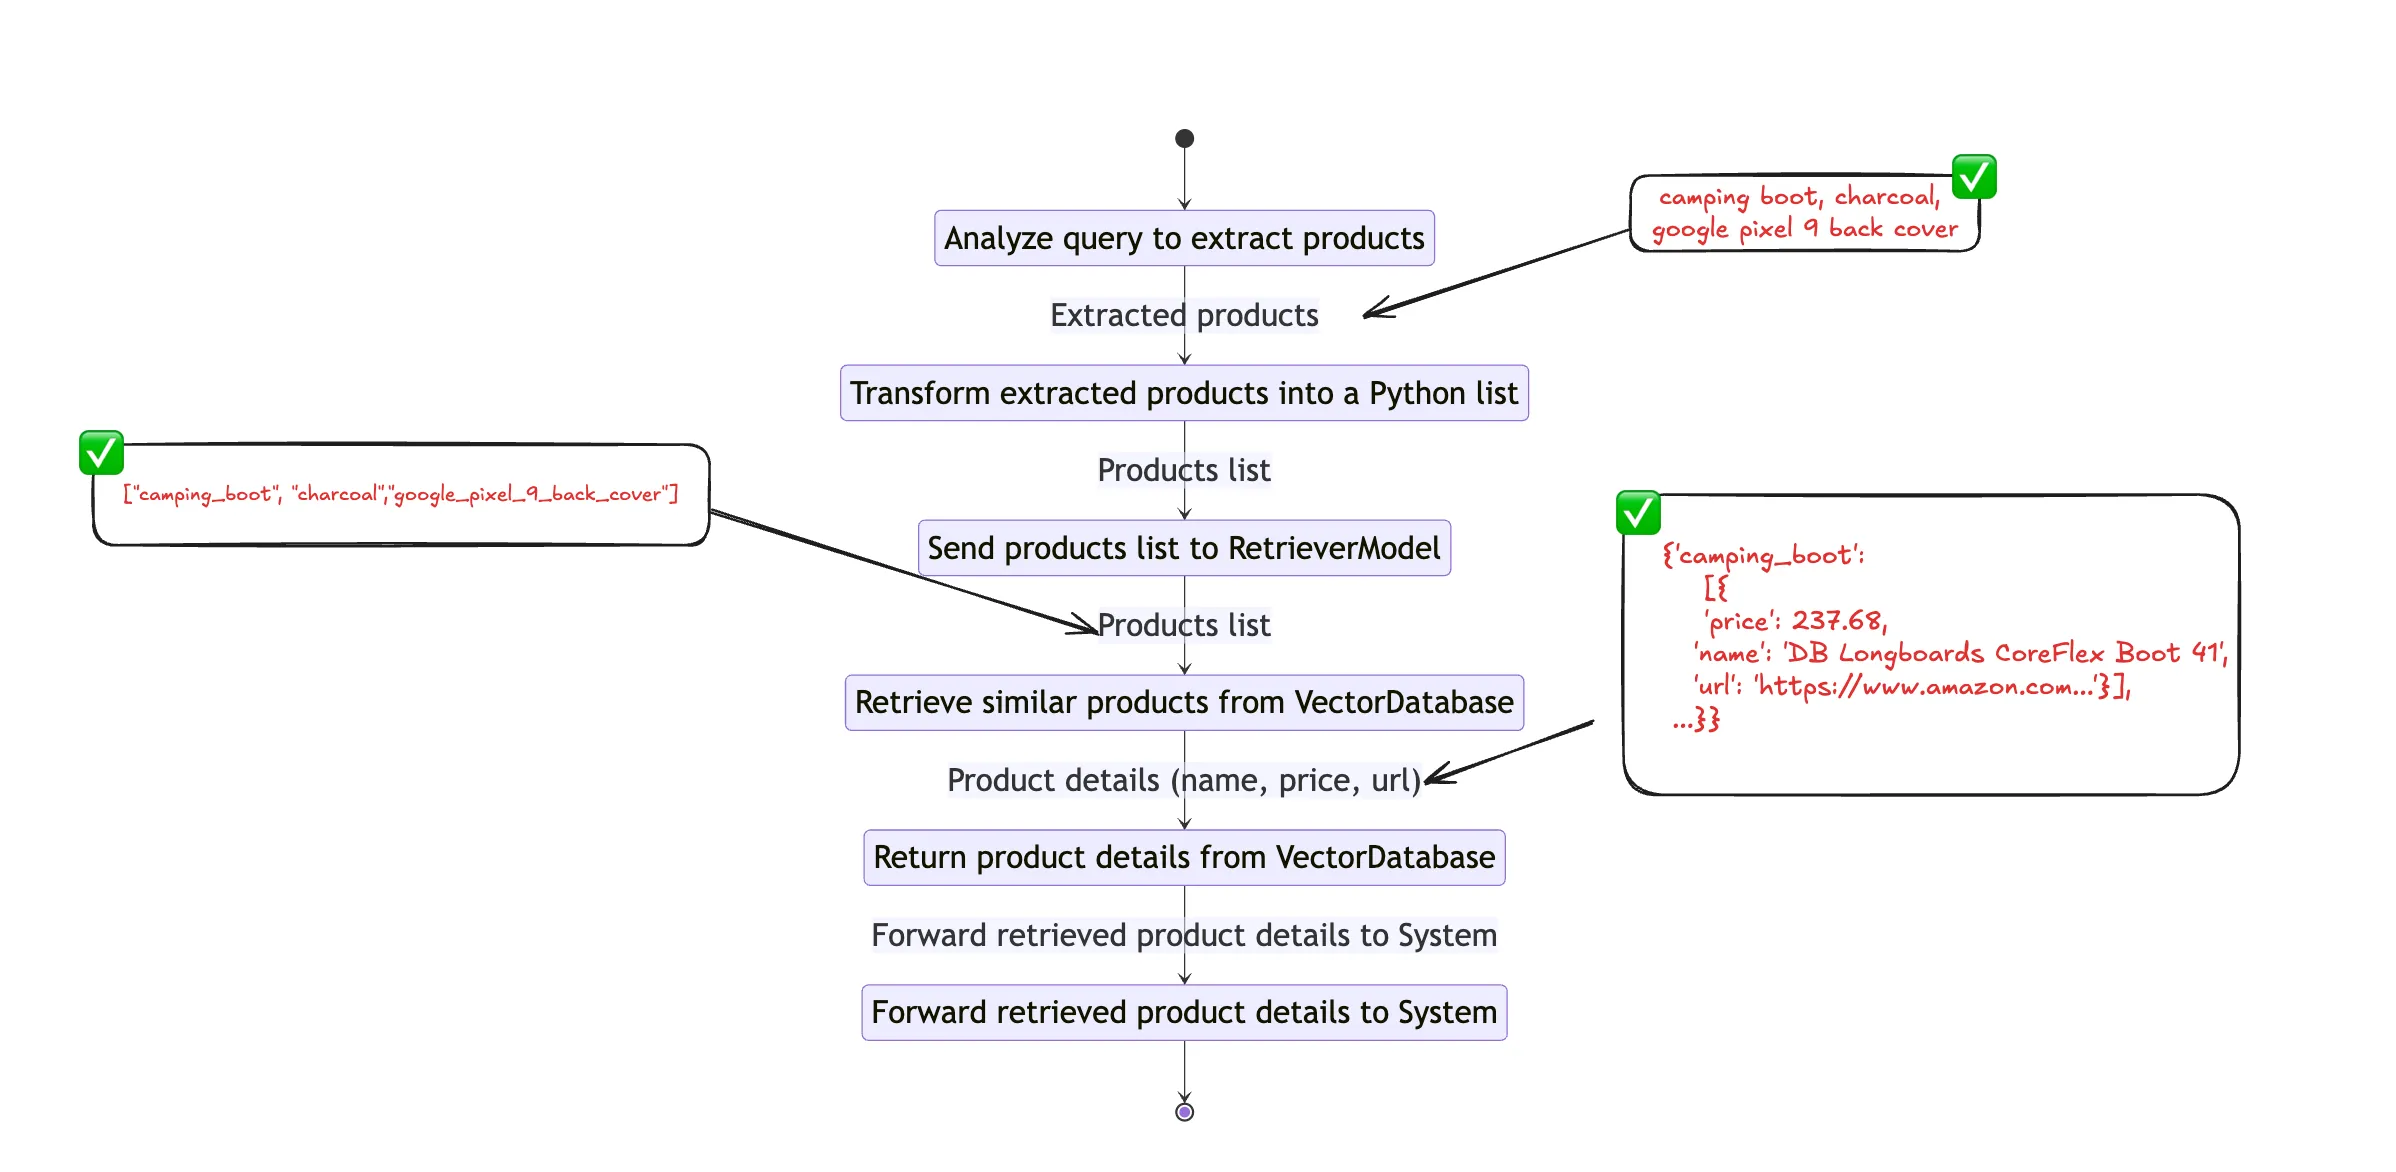

With that, we have completed our first tool for the agent. Let’s see whether it works as expected.

In [29]:
## Testing functions
product_identifier_func(query)

Batches: 100%|██████████| 1/1 [00:00<00:00, 27.58it/s]


{'crossbow': [{'price': 237.68,
   'name': 'DB Longboards CoreFlex Crossbow 41" Bamboo Fiberglass Longboard Complete',
   'url': 'https://www.amazon.com/DB-Longboards-CoreFlex-Fiberglass-Longboard/dp/B07KMVJJK7'}],
 'woodstock_puzzle': {'price': 17.49,
  'name': 'Woodstock- Collage 500 pc Puzzle',
  'url': 'https://www.amazon.com/Woodstock-Collage-500-pc-Puzzle/dp/B07MX21WWX'}}

It worked!! However, it’s worth noting the return output schema. You can see the general schema below.

```python
{
    "product_key": {
        "name": "string",
        "price": "float",
        "url": "string"
    }
}
```

That’s exactly what we have advised the model to produce in the RAG pipeline. As a next step, let’s build an optional tool called find_budget_friendly_option.

In [16]:
def find_budget_friendly_option(selected_product_details):
    budget_friendly_options = {}
    
    for category, items in selected_product_details.items():
        if isinstance(items, list):
            lowest_price_item = min(items, key=lambda x: x['price'])
        else:
            lowest_price_item = items
        
        budget_friendly_options[category] = lowest_price_item
    
    return budget_friendly_options

Alright, now we have the most critical part of this application, which is allowing the agent to use these functions when necessary. As we discussed earlier, this is made possible via a model-specific tool schema. So we have to find the tool schema specific for the selected model. Luckily, it’s mentioned in the Groq/Llama-3-Groq-70B-Tool-Use's model card here. Let's adapt that to our use case.

In [18]:
product_identifier_func("I wat to purchase Pokemon for my kids, and crossbow for myself")

Batches: 100%|██████████| 1/1 [00:00<00:00, 63.43it/s]


{'pokemon': [{'price': 38.49,
   'name': 'Pokemon TCG: Sun and Moon Crimson Invasion Elite Trainer Box',
   'url': 'https://www.amazon.com/Pokemon-TCG-Crimson-Invasion-Trainer/dp/B074NCGNX2'},
  {'price': 29.12,
   'name': "Rubie's Child's Pokemon Deluxe Pikachu Costume, X-Small",
   'url': 'https://www.amazon.com/Rubies-Deluxe-Pikachu-Pokemon-Costume/dp/B07BZJM592'}],
 'crossbow': {'price': 237.68,
  'name': 'DB Longboards CoreFlex Crossbow 41" Bamboo Fiberglass Longboard Complete',
  'url': 'https://www.amazon.com/DB-Longboards-CoreFlex-Fiberglass-Longboard/dp/B07KMVJJK7'}}

## Finalizing Chat Template

In [19]:
chat_template = '''<|start_header_id|>system<|end_header_id|>

You are a function calling AI model. You are provided with function signatures within <tools></tools> XML tags. You may call one or more functions to assist with the user query. Don't make assumptions about what values to plug into functions. For each function call return a json object with function name and arguments within <tool_call></tool_call> XML tags as follows:
<tool_call>
{"name": <function-name>,"arguments": <args-dict>}
</tool_call>

Here are the available tools:
<tools>
    {
        "name": "product_identifier_func",
        "description": "To understand user interested products and its details",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": "The query to use in the search. Infer this from the user's message. It should be a question or a statement"
                }
            },
            "required": ["query"]
        }
    },
    {
        "name": "find_budget_friendly_option",
        "description": "Get the most cost-friendly option. If selected_product_details has morethan one key this should return most cost-friendly options",
        "parameters": {
            "type": "object",
            "properties": {
                "selected_product_details": {
                    "type": "dict",
                    "description": "Input data is a dictionary where each key is a category name, and its value is either a single dictionary with 'price', 'name', and 'url' keys or a list of such dictionaries; example: {'category1': [{'price': 10.5, 'name': 'item1', 'url': 'http://example.com/item1'}, {'price': 8.99, 'name': 'item2', 'url': 'http://example.com/item2'}], 'category2': {'price': 15.0, 'name': 'item3', 'url': 'http://example.com/item3'}}"
                }
            },
            "required": ["selected_product_details"]
        }
    }
</tools><|eot_id|><|start_header_id|>user<|end_header_id|>

I need to buy a crossbow<|eot_id|><|start_header_id|>assistant<|end_header_id|>

<tool_call>
{"id":"call_deok","name":"product_identifier_func","arguments":{"query":"I need to buy a crossbow"}}
</tool_call><|eot_id|><|start_header_id|>tool<|end_header_id|>

<tool_response>
{"id":"call_deok","result":{'crossbow': {'price': 237.68,'name': 'crossbow','url': 'https://www.amazon.com/crossbow/dp/B07KMVJJK7'}}}
</tool_response><|eot_id|><|start_header_id|>assistant<|end_header_id|>
'''

Now there are only a few steps left. Before doing anything, let’s test our agent.

In [20]:
## Testing template
messages = [
    ChatMessage.from_system(
        chat_template
    ),
    ChatMessage.from_user("I need to buy a crossbow for my child and Pokémon for myself."),
]

chat_generator = get_chat_generator()
response = chat_generator.run(messages=messages)
pprint(response)

{'replies': [ChatMessage(content='<tool_call>\n'
                                 '{"id": 0, "name": "product_identifier_func", '
                                 '"arguments": {"query": "I need to buy a '
                                 'crossbow for my child"}}\n'
                                 '</tool_call>\n'
                                 '<tool_call>\n'
                                 '{"id": 1, "name": "product_identifier_func", '
                                 '"arguments": {"query": "I need to buy a '
                                 'Pokemon for myself"}}\n'
                                 '</tool_call>',
                         role=<ChatRole.ASSISTANT: 'assistant'>,
                         name=None,
                         meta={'finish_reason': 'stop',
                               'index': 0,
                               'model': 'llama3-groq-70b-8192-tool-use-preview',
                               'usage': {'completion_time': 0.217823967,
              

With that, we have completed about 90% of our work.

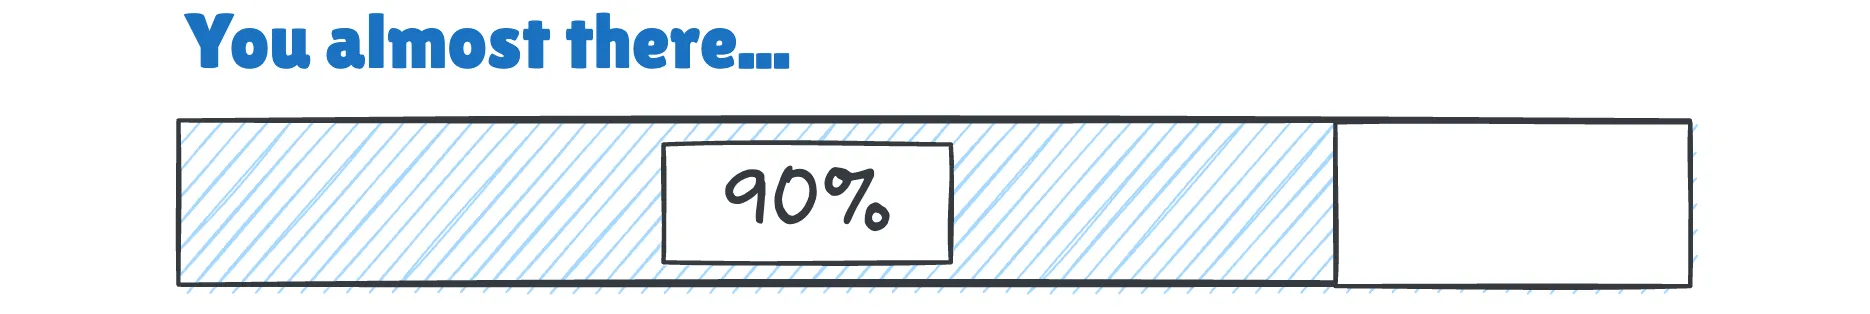

One thing you probably noticed in the above response is that tool calls are enclosed using the XML tag <tool_call>. Therefore, we have to build some mechanism to extract the tool_call object.

In [21]:
## For extracting tool calls
def extract_tool_calls(tool_calls_str):
    json_objects = re.findall(r'<tool_call>(.*?)</tool_call>', tool_calls_str, re.DOTALL)
    
    result_list = [json.loads(obj) for obj in json_objects]
    
    return result_list

In [22]:
available_functions = {
    "product_identifier_func": product_identifier_func, 
    "find_budget_friendly_option": find_budget_friendly_option
    }

With this step completed, we can directly access the agent’s response when it calls a tool. Now the only thing pending is to get the tool call object and execute the function accordingly. Let’s complete that piece too.

```python
messages.append(ChatMessage.from_user(message))
response = chat_generator.run(messages=messages)

if response and "<tool_call>" in response["replies"][0].content:
    function_calls = extract_tool_calls(response["replies"][0].content)
    for function_call in function_calls:
        # Parse function calling information
        function_name = function_call["name"]
        function_args = function_call["arguments"]

        # Find the corresponding function and call it with the given arguments
        function_to_call = available_functions[function_name]
        function_response = function_to_call(**function_args)

        # Append function response to the messages list using `ChatMessage.from_function`
        messages.append(ChatMessage.from_function(content=json.dumps(function_response), name=function_name))
        response = chat_generator.run(messages=messages)
```

Now it’s time to join each component together and build proper chat application. I am going to use gradio for that purpose.

In [23]:
messages = [
    ChatMessage.from_system(
        chat_template
    )
]

chat_generator = get_chat_generator()

def chatbot_with_fc(message, messages):
    messages.append(ChatMessage.from_user(message))
    response = chat_generator.run(messages=messages)

    while True:
        if response and "<tool_call>" in response["replies"][0].content:
            function_calls = extract_tool_calls(response["replies"][0].content)
            for function_call in function_calls:
                # Parse function calling information
                function_name = function_call["name"]
                function_args = function_call["arguments"]
                # print(f"Calling function: {function_name} with arguments: {function_args}")

                # Find the corresponding function and call it with the given arguments
                function_to_call = available_functions[function_name]
                function_response = function_to_call(**function_args)

                # Append function response to the messages list using `ChatMessage.from_function`
                messages.append(ChatMessage.from_function(content=json.dumps(function_response), name=function_name))
                response = chat_generator.run(messages=messages)

        # Regular Conversation
        else:
            messages.append(response["replies"][0])
            break
    return response["replies"][0].content

def run():
    print("AI Purchase Assistant")
    print("Ask me about products you want to buy!")
    
    while True:
        user_input = input("Your message: ")
        if user_input.lower() in ['exit', 'quit']:
            break
        
        response_content = chatbot_with_fc(user_input, messages)
        print("Response:", response_content)

In [ ]:
def chatbot_with_fc(message, messages):
    messages.append(ChatMessage.from_user(message))
    response = chat_generator.run(messages=messages)

    while True:
        if response and "<tool_call>" in response["replies"][0].content:
            function_calls = extract_tool_calls(response["replies"][0].content)
            for function_call in function_calls:
                # Parse function calling information
                function_name = function_call["name"]
                function_args = function_call["arguments"]

                # Find the corresponding function and call it with the given arguments
                function_to_call = available_functions[function_name]
                function_response = function_to_call(**function_args)

                # Append function response to the messages list using `ChatMessage.from_function`
                messages.append(ChatMessage.from_function(content=json.dumps(function_response), name=function_name))
                response = chat_generator.run(messages=messages)

        # Regular Conversation
        else:
            messages.append(response["replies"][0])
            break
    return response["replies"][0].content

In [26]:
import gradio as gr

messages = [ChatMessage.from_system(chat_template)]
chat_generator = get_chat_generator()

def chatbot_with_fc(message, messages):
    messages.append(ChatMessage.from_user(message))
    response = chat_generator.run(messages=messages)

    while True:
        if response and "<tool_call>" in response["replies"][0].content:
            function_calls = extract_tool_calls(response["replies"][0].content)
            for function_call in function_calls:
                # Parse function calling information
                function_name = function_call["name"]
                function_args = function_call["arguments"]

                # Find the corresponding function and call it with the given arguments
                function_to_call = available_functions[function_name]
                function_response = function_to_call(**function_args)

                # Append function response to the messages list using `ChatMessage.from_function`
                messages.append(ChatMessage.from_function(content=json.dumps(function_response), name=function_name))
                response = chat_generator.run(messages=messages)

        # Regular Conversation
        else:
            messages.append(response["replies"][0])
            break
    return response["replies"][0].content

# Define Gradio interface function
def chatbot_interface(user_input, state):
    response_content = chatbot_with_fc(user_input, state)
    return response_content, state

# Gradio app
with gr.Blocks() as demo:
    gr.Markdown("# AI Purchase Assistant")
    gr.Markdown("Ask me about products you want to buy!")
    
    state = gr.State(value=messages)
    
    with gr.Row():
        user_input = gr.Textbox(label="Your message:")
        response_output = gr.Markdown(label="Response:")
    
    user_input.submit(chatbot_interface, [user_input, state], [response_output, state])
    gr.Button("Send").click(chatbot_interface, [user_input, state], [response_output, state])


demo.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


That’s all, we have build the Llama 3 based AI Agent 🤖 with function calling capability.

## Conclusion

When building an AI agent-based system, it’s worth noting the time taken to finish a task and the number of API calls (tokens) used to complete a single task. Furthermore, reducing hallucinations is the biggest challenge for us to tackle, and it is an active research area as well. Hence, there is no rule of thumb for use in LLM and agent system building. So, you have to work patiently and tactically to get the AI agent, or in other words, the LLM, on the right track.

## Reference:

Introducing Llama 3.1: Our most capable models to date - [Link](https://ai.meta.com/blog/meta-llama-3-1/?source=post_page-----7e74f79d1ccc--------------------------------)

Groq/Llama-3-Groq-70B-Tool-Use · Hugging Face - [Link](https://huggingface.co/Groq/Llama-3-Groq-70B-Tool-Use?source=post_page-----7e74f79d1ccc--------------------------------)

https://docs.together.ai/docs/llama-3-function-calling